# Hypothesis Testing: Temperature Effect on Rushing Yards

## Introduction
Testing the hypothesis that: **Rushing yardage is higher in colder temperatures compared to warmer temperatures.**

### Hypothesis Statement
- **Null Hypothesis (H₀)**: The average rushing yardage in colder temperatures is equal to the average rushing yardage in warmer temperatures.
- **Alternative Hypothesis (H₁)**: The average rushing yardage in colder temperatures is greater than the average rushing yardage in warmer temperatures.

### Purpose
The purpose of this analysis is to investigate the impact of temperature on rushing yardage in NFL games, specifically if colder games result in higher average rushing yardage. This relationship can help provide expectations on team performance and gameplans during colder games. 

### Methodology
To test this hypothesis, we will conduct a [type of test, e.g., independent t-test] using historical NFL game data.
1. **Data Collection**: Gather NFL game data focusing on team rushing yardage and average temperature from each game. 
2. **Data Cleaning & Preparation**: Clean data by adressing missing values and inconsistencies. Categorize the average temperture (e.g., Freezing, Cold, Cool, Warm, Hot).
3. **Exploratory Data Analysis (EDA)**: Perform initial analysis to understand distributions of rushing yardage across temperature categories. Create visualizations (box plots, histograms, etc.) to help visualize comparisons.
4. **Hypothesis Testing**: Use an independent t-test to compare average rushing yardage between categorized temperatures. T-test will help determine statistical significance.
5. **Result Interpretation**: Based on the p-value from hypothesis test, determine to accept or reject null hypothesis. Low p-value of (0.05) will indicate the observed difference in rushing yards across temperature categories is statistically significant.
6. **Conclusion**: Interpret results in the context of an NFL game. What can a fan expect from a team and players performance based on weather predictions for the game. 


In [15]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Collection
Gather NFL game data focusing on team rushing yardage and average temperature from each game. 

#### Design Decisions:
1. For each individual NFL game, combine each Team's Rushing Attempts and Rushing Yards. This focuses purely on total rushing yards in a game compared to each individual teams rushing performance in said game.
2. Filter out Pre-Season Games. While this removes a large chunk of data that experiences warmer weather (due to Summer and early Fall months), pre-season games often are not consistent with a typical NFL games statistics.
3. Filter out games where the Home Team plays in a Dome stadium. Dome's eliminate the weather variance, so omit them from the dataset.
4. Filter out Super Bowls as the location of Super Bowls are not dependent on the home team and the weather data associated does not currently scrape for the independent location (i.e., the pipeline can scrape for the city of the home team, but the game is likely played elsewhere). 

In [16]:
%load_ext sql
conn = sqlite3.connect('..\\..\\nfl_fantasy.db')
cursor = conn.cursor()
%sql sqlite:///C:\Users\Jrdes\Desktop\NFL\NFL-Analytics\nfl_fantasy.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [17]:
%%sql rushing_yds_weather_query <<
SELECT 
    g.GAME_DATE,
    g.GAME_WEEK,
    g.SEASON_ID,
    g.GAME_ID,
    g.GAME_TYPE,
    tgs.TOTAL_RUSHING_ATTEMPTS,
    tgs.TOTAL_RUSHING_YARDS,
    ROUND(w.AVG_TEMPERATURE_FAHRENHEIT, 1) AS AVG_TEMPERATURE_FAHRENHEIT

FROM 
    Game g
JOIN 
    (SELECT GAME_ID, 
            SUM(OFF_RUSHING_ATTEMPTS) AS TOTAL_RUSHING_ATTEMPTS,
            SUM(OFF_RUSHING_YARDS) AS TOTAL_RUSHING_YARDS
     FROM Team_Game_Stats
     GROUP BY GAME_ID) AS tgs
    ON g.GAME_ID = tgs.GAME_ID
JOIN 
    (SELECT GAME_ID, 
            AVG(TEMPERATURE) AS AVG_TEMPERATURE_FAHRENHEIT
     FROM Weather
     GROUP BY GAME_ID) AS w
    ON g.GAME_ID = w.GAME_ID
JOIN
    TEAM home_team ON g.HOME_TEAM_ID = home_team.TEAM_ID

WHERE 
    g.GAME_TYPE != "Preseason"
    AND home_team.STADIUM_TYPE != "Dome"
    AND g.GAME_WEEK != "Super Bowl"

GROUP BY
    g.GAME_ID, 
    g.GAME_DATE,
    g.GAME_WEEK,
    g.SEASON_ID;


 * sqlite:///C:\Users\Jrdes\Desktop\NFL\NFL-Analytics\nfl_fantasy.db
Done.
Returning data to local variable rushing_yds_weather_query


In [18]:
rushing_yds_weather_df = rushing_yds_weather_query.DataFrame()

## 2. **Data Cleaning & Preparation**:
- **A.** Check for missing values.
- **B.** Check for data inconsistencies.
- **C.** Categorize weather temperatures into buckets (e.g., very cold, cold, average, warm, very warm, etc.).


##### A. Check for missing values.

In [19]:
# Check if there is any missing values in datafrmae
missing_values = rushing_yds_weather_df.isnull().sum()

In [20]:
print("Missing Values:\n", missing_values)

Missing Values:
 GAME_DATE                     0
GAME_WEEK                     0
SEASON_ID                     0
GAME_ID                       0
GAME_TYPE                     0
TOTAL_RUSHING_ATTEMPTS        0
TOTAL_RUSHING_YARDS           0
AVG_TEMPERATURE_FAHRENHEIT    0
dtype: int64


##### B. Check for data inconsistencies.

In [27]:
# Review data types, and preview dataset
print(rushing_yds_weather_df.dtypes)
print(rushing_yds_weather_df.head())

GAME_DATE                      object
GAME_WEEK                      object
SEASON_ID                      object
GAME_ID                        object
GAME_TYPE                      object
TOTAL_RUSHING_ATTEMPTS          int64
TOTAL_RUSHING_YARDS             int64
AVG_TEMPERATURE_FAHRENHEIT    float64
TEMPERATURE_CATEGORY           object
dtype: object
    GAME_DATE GAME_WEEK SEASON_ID           GAME_ID       GAME_TYPE  \
0  09-11-2022    Week 1      2022  20220911_BAL@NYJ  Regular Season   
1  09-11-2022    Week 1      2022  20220911_CLE@CAR  Regular Season   
2  09-11-2022    Week 1      2022  20220911_IND@HOU  Regular Season   
3  09-11-2022    Week 1      2022  20220911_JAX@WSH  Regular Season   
4  09-11-2022    Week 1      2022   20220911_KC@ARI  Regular Season   

   TOTAL_RUSHING_ATTEMPTS  TOTAL_RUSHING_YARDS  AVG_TEMPERATURE_FAHRENHEIT  \
0                      38                  146                        69.0   
1                      58                  271               

Temperature Summary:
 count    443.000000
mean      58.286456
std       18.109615
min       -7.500000
25%       46.100000
50%       58.600000
75%       71.900000
max      102.400000
Name: AVG_TEMPERATURE_FAHRENHEIT, dtype: float64


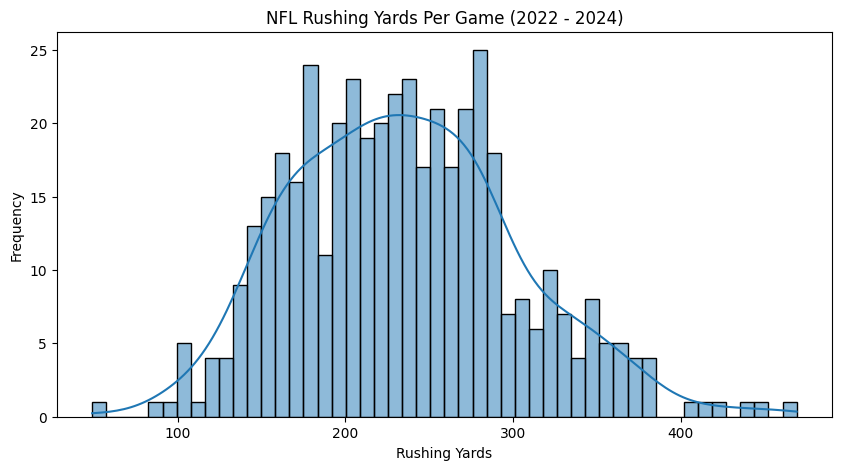

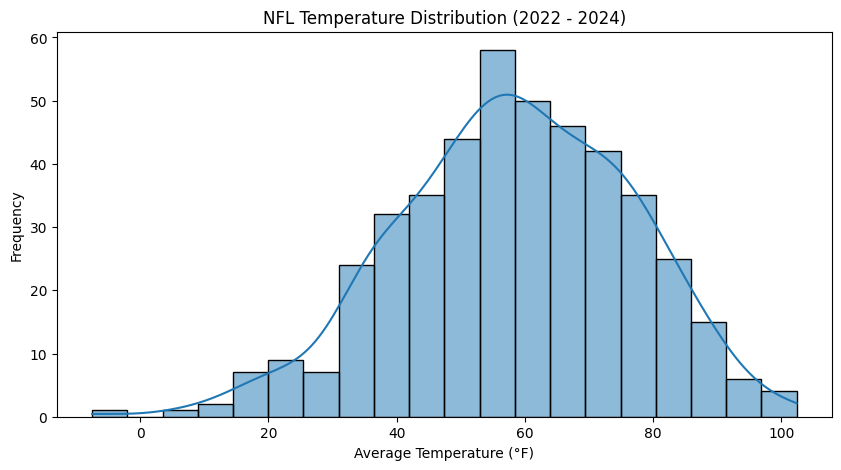

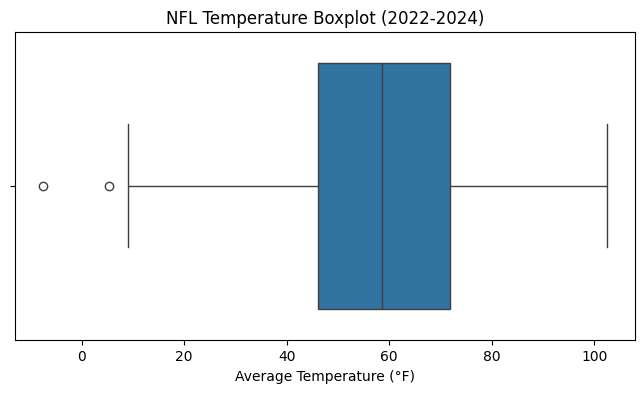

In [29]:
# Preview some statisitcs of the AVG_TEMPERATURE_FAHRENHEIT field. Make sure the data makes sense
temperature_summary = rushing_yds_weather_df['AVG_TEMPERATURE_FAHRENHEIT'].describe()
print("Temperature Summary:\n", temperature_summary)

# Histogram for rushing yards distrubution
plt.figure(figsize=(10, 5))
sns.histplot(rushing_yds_weather_df['TOTAL_RUSHING_YARDS'], bins=50, kde=True)
plt.title('NFL Rushing Yards Per Game (2022 - 2024)')
plt.xlabel('Rushing Yards')
plt.ylabel('Frequency')
plt.show()

# Histogram for temperature distribution
plt.figure(figsize=(10, 5))
sns.histplot(rushing_yds_weather_df['AVG_TEMPERATURE_FAHRENHEIT'], bins=20, kde=True)
plt.title('NFL Temperature Distribution (2022 - 2024)')
plt.xlabel('Average Temperature (°F)')
plt.ylabel('Frequency')
plt.show()

# Boxplot for a quick look at any extreme values
plt.figure(figsize=(8, 4))
sns.boxplot(x=rushing_yds_weather_df['AVG_TEMPERATURE_FAHRENHEIT'])
plt.title('NFL Temperature Boxplot (2022-2024)')
plt.xlabel('Average Temperature (°F)')
plt.show()

##### C. Categorize weather temperatures into buckets (e.g., Freezing, Cold, Cool, Warm, Hot).

In [24]:
# Define function to categorize temperature into five buckets
def categorize_temperature(temp):
    if temp <= 32:
        return "Freezing"
    elif 33 <= temp <= 45:
        return "Cold"
    elif 46 <= temp <= 60:
        return "Cool"
    elif 61 <= temp <= 75:
        return "Warm"
    else:
        return "Hot"

# Apply categorization to create a new column
rushing_yds_weather_df['TEMPERATURE_CATEGORY'] = rushing_yds_weather_df['AVG_TEMPERATURE_FAHRENHEIT'].apply(categorize_temperature)

# Verify the new column
print(rushing_yds_weather_df[['AVG_TEMPERATURE_FAHRENHEIT', 'TEMPERATURE_CATEGORY']].head())


   AVG_TEMPERATURE_FAHRENHEIT TEMPERATURE_CATEGORY
0                        69.0                 Warm
1                        82.8                  Hot
2                        92.2                  Hot
3                        78.4                  Hot
4                       100.0                  Hot


## 3. Exploratory Data Analysis (EDA): 
Perform initial analysis to understand distributions of rushing yardage across temperature categories. Create visualizations (box plots, histograms, etc.) to help visualize comparisons.

#### Initial stat overview of Temperature Cateogry and Rushing Yards comparision

In [25]:
# Group by temperature category and calculate summary stats for rushing yards
rushing_summary = rushing_yds_weather_df.groupby('TEMPERATURE_CATEGORY')['TOTAL_RUSHING_YARDS'].describe()
print("Rushing Yardage Summary by Temperature Category:\n", rushing_summary)

Rushing Yardage Summary by Temperature Category:
                       count        mean        std    min    25%    50%  \
TEMPERATURE_CATEGORY                                                      
Cold                   69.0  242.347826  60.195472  128.0  199.0  246.0   
Cool                  131.0  239.076336  66.885507   49.0  185.0  238.0   
Freezing               31.0  244.129032  69.766631  113.0  202.0  251.0   
Hot                    97.0  223.773196  65.560485  100.0  182.0  215.0   
Warm                  115.0  232.556522  71.204202   86.0  178.0  229.0   

                        75%    max  
TEMPERATURE_CATEGORY                
Cold                  282.0  376.0  
Cool                  280.5  469.0  
Freezing              281.0  366.0  
Hot                   263.0  419.0  
Warm                  276.0  451.0  


**Obervations**:
- Colder temperature categories (Freezing, Cold, Cool) all have a higher averages of rushing yards compared to the warmer categories.
- Freezing and Cold categories have the highest average rushing yards (244 and 242 respectively), while the Hot category has an average of 223 rushing yards. 
- Freezing games also have the highest median of rushing yards, while Hot has the lowest, suggesting taht coldr games consistently result in higher yardage than warmer games. This trend is seemingly followed by the lower quartile (25%) range and third quartile (75%) range. 
- The standard devatiation across all categories is quite similar. 

#### Box plot | Rushing Yards by Temperature Category

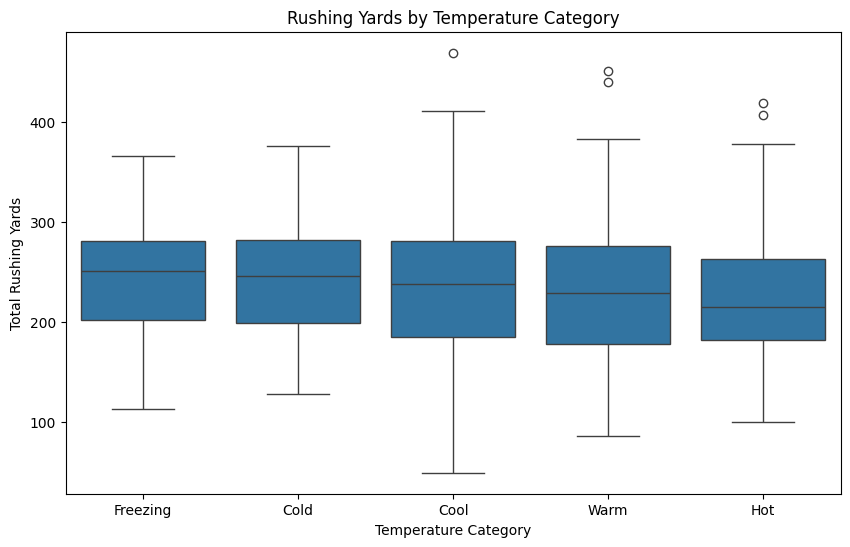

In [26]:
plt.figure(figsize=(10,6))
sns.boxplot(x='TEMPERATURE_CATEGORY', y='TOTAL_RUSHING_YARDS', data=rushing_yds_weather_df, order=["Freezing", "Cold", "Cool", "Warm", "Hot"])
plt.title('Rushing Yards by Temperature Category')
plt.xlabel('Temperature Category')
plt.ylabel('Total Rushing Yards')
plt.show()

**Observations**:
- At first glance, there is not a lot of disparity between each temperature category. A closer look seems to show the inner quartile range (IQR) slighlty drops as the temperature category rises to warmer temperatures. The median also slightly goes down in warmer categories.
- The Cool category has the largest IQR and widest range representing a lot more variability in this category.


#### Scatter Plot | Rushing Yards vs Average Temperature

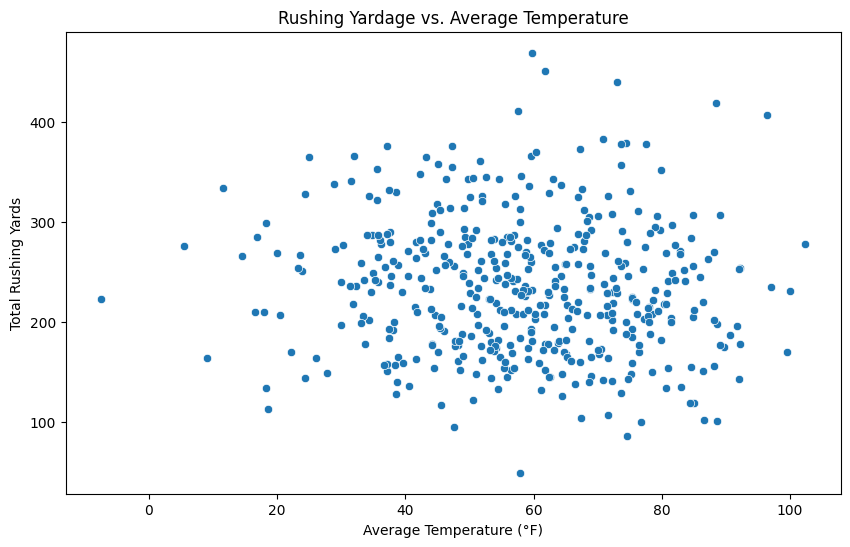

In [31]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='AVG_TEMPERATURE_FAHRENHEIT', y='TOTAL_RUSHING_YARDS', data=rushing_yds_weather_df)
plt.title('Rushing Yardage vs. Average Temperature')
plt.xlabel('Average Temperature (°F)')
plt.ylabel('Total Rushing Yards')
plt.show()

**Observations**:
- There does not appear to be a strong correlation between average temperature and total rushing yards. The points, representing individual games, are fairly spread apart not showing any trends.
- It appears that most points cluster between 40°-80°, with most yards between 150-350.
- There are a few outliers of some games with over 400 total rushing yards, but they are spread among various temperatures. 


## 4. Hypothesis Testing
Use an independent t-test to compare average rushing yardage between categorized temperatures. T-test will help determine statistical significance.